# Build ALL* the classifiers!
© Explore Data Science Academy

\* well, not ALL the classifiers. Some we're leaving up to you to play with.

## Learning Objectives

By the end of this train, you should be able to:

* Build multiple types of classification models; and
* Figure out which model is better at fitting to your dataset.

## Outline

In this train we will:
* Pre-process the MBTI dataset;
* Build seven different types of classification model;
* Perform cross validation on these models; and 
* Visualise the different models using dummy data.

## Introduction

In this train, we will throw some of the most common classifiers at the MBTI problem!  Let's not worry too much about what each algorithm is doing. Instead, we will focus on how to tell which model is likely to be better at solving this problem. To do so, we will fit the following classifiers to the MBTI dataset:

* Logistic Regression
* K Nearest Neighbours (KNN)
* Support Vector Machines (SVM)
* Decision Trees
* [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Then we will leave it up to you to play with a few additional models:

* [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* [LDA / QDA](https://scikit-learn.org/stable/modules/lda_qda.html)
* [Neural Network](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

This approach highlights a key principle in machine learning.  The best models are built through **iteration**. We need to be able to implement a 'quick and dirty' model that should give us a good idea of how to proceed in finding a better solution to a particular problem. The quicker we can generate a couple of results, the quicker we can come up with new ideas of how to proceed.

### Imports
To start, lets import everything we will require. This will be some feature extraction methods for text, methods to split our data, and all the models we want to train.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


Bad key "text.kerning_factor" on line 4 in
/Users/kierandonnelly/opt/anaconda3/envs/acad/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Data Pre-Processing

You should be familiar with these steps from previous trains on handling text data, specifically the MBTI dataset. Can you think of, and implement, additional data cleaning and optimisation steps to improve our classification model?

**Note:** Depending on the machine you're using and the quality of internet connection, the following cell may take several minutes to execute. 

In [2]:
## Read the data
print ('Reading the data into Pandas DF...')
mbti = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/classification_sprint/mbti_train.csv')

## Split the rows
print ('Seperating data...')
all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'post'])

## Remove urls
print ('Removing URLs...')
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_mbti['post'] = all_mbti['post'].replace(to_replace = pattern_url, value = subs_url, regex = True)

# Make lower case
print ('Lowering case...')
all_mbti['post'] = all_mbti['post'].str.lower()

# Remove punctuation
import string
print ('Cleaning punctuation...')
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
all_mbti['post'] = all_mbti['post'].apply(remove_punctuation_numbers)

Reading the data into Pandas DF...
Seperating data...
Removing URLs...
Lowering case...
Cleaning punctuation...


We will only be looking at the Introvert / Extrovert dimension here.  Can you figure out how to use this script to build models for the different types? 

In [3]:
all_mbti['I'] = all_mbti['type'].apply(lambda x: x[0] == 'I').astype('int')
y = all_mbti['I']
y.shape

(316548,)

Now lets fit the data to the Count Vectorizer, removing all English stop words.

In [4]:
vect = CountVectorizer(stop_words='english', min_df= .01)
X = vect.fit_transform(all_mbti['post'])

We'll now save the dataset so that you don't have to do the pre-processing again if you come back to revise this train.

In [5]:
pd_intro = pd.DataFrame(X.A, columns=vect.get_feature_names())
pd_intro['y'] = y
pd_intro.to_csv('introvert_mbti_count_vector1.csv')

We have alot of training data here!  To speed the alogorithms up and illustrate the effects, we will only be using the first 5,000 rows of data.  Please play around with this $n$ to get a feel of how each algorithm responds to more data (from an accuracy and training time point of view).

In [6]:
n = 5000
X_train, X_test, y_train, y_test = train_test_split(X[:n].toarray(), y[:n])

If we assume that everyone is introverted, we would get this accuracy:

In [7]:
np.mean(y_train)

0.7997333333333333

## Let's build some classification models!

In the next two cells, we will define the model names and call the model implementation classes. Note how some of the classifiers need input variables.  These are examples of **hyperparameters**. 

In [9]:
names = ['Logistic Regression', 'Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',          
         'Decision Tree', 'Random Forest',  'AdaBoost']

In [10]:
classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier()
]

While this next cell is running, see if you can tell which algorithm takes the longest to train. Why do you think this is so?

In [11]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred)
    recall    = metrics.recall_score(y_train, y_pred)
    
    f1        = metrics.f1_score(y_train, y_pred)    
    f1_test   = metrics.f1_score(y_test, y_pred_test)    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...


/Users/kierandonnelly/opt/anaconda3/envs/acad/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...


/Users/kierandonnelly/opt/anaconda3/envs/acad/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


... predicting
... scoring
... All done!


That's all done! Now let's take a look at the results.

In [12]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
RBF SVM,0.956000,0.951274,0.995999,0.973123,0.889188,1.935700
Decision Tree,0.805867,0.807141,0.994998,0.891278,0.885407,0.009904
AdaBoost,0.801067,0.803067,0.995332,0.888922,0.887003,0.277451
Linear SVM,0.799733,0.799733,1.000000,0.888724,0.889382,0.983020
Random Forest,0.799733,0.799733,1.000000,0.888724,0.889382,0.013484
Logistic Regression,0.799733,0.801664,0.995999,0.888327,0.887600,0.012241
Nearest Neighbors,0.790933,0.866358,0.873291,0.869811,0.808639,0.023597


This is way too many numbers to comprehend. Let's plot these values to see if we can make sense of them.

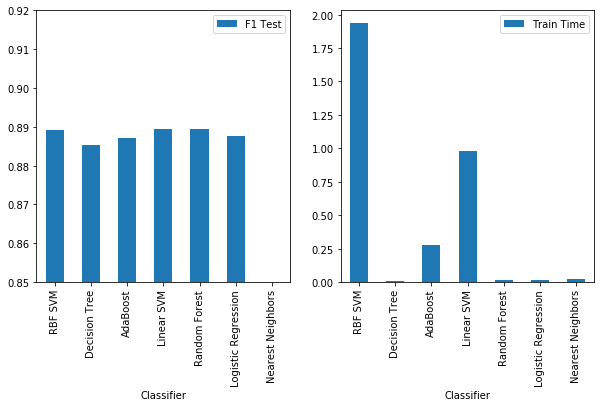

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.85,0.92])
results.plot(y='Train Time', kind='bar', ax=ax[1])

To better understand the performance of some of the models, lets view a few confusion matrices and classification reports of their results.

In [15]:
confusion['Logistic Regression']

array([[  12,  739],
       [  12, 2987]])

In [16]:
confusion['RBF SVM']

array([[ 598,  153],
       [  12, 2987]])

In [17]:
print(class_report['RBF SVM'])

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       751
           1       0.95      1.00      0.97      2999

    accuracy                           0.96      3750
   macro avg       0.97      0.90      0.93      3750
weighted avg       0.96      0.96      0.95      3750



Can you use the above metrics to analyse the performance of the models? Which model do you think outperforms the rest?

## Model Validation

But how do we know if these models are robust?  Model validation is the process of checking if our model produces reliable results. In order to make an informed choice, we need a way to *validate* that our model and our hyperparameters are a good fit to the data. While this may sound simple, there are some pitfalls that you must avoid in order to do this effectively. 

### K-Fold Cross Validation

In the rest of this train, we consider a common approach to validation called `k-fold cross validation`. In its simplest form, k-fold fits a single model to a number of different versions of the test-train split and compares how volatile the results of the model are.

If you need a bit of a refresher on `k-fold` cross validation, or train test split in general, you can rewatch the following video from the Regression sprint [Regression | Train/Test Split](https://www.youtube.com/watch?v=T7PzngnKWq0) or read through the K-Fold Cross validation [Tutorial from Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/).

Cross validation can be easily implemented using `sklearn`. Let's do that for our Logistic Regression model and print out the performance of each fold.

In [18]:
model = models['Logistic Regression']
print(cross_val_score(model, X[:n].toarray(), y[:n]))

[0.799 0.794 0.788 0.798 0.798]


Let's now do the same for each of our models and print out the mean and standard deviation of each model's cross validation.

In [19]:
cv = []
for name, model in models.items():
    print ()
    print(name)
    scores = cross_val_score(model, X=X[:n].toarray(), y=y[:n], cv=10)
    print("Accuracy: {:0.2f} (+/- {:0.4f})".format(scores.mean(), scores.std()))
    cv.append([name, scores.mean(), scores.std() ])
    
cv = pd.DataFrame(cv, columns=['Model', 'CV_Mean', 'CV_Std_Dev'])
cv.set_index('Model', inplace=True)


Logistic Regression
Accuracy: 0.80 (+/- 0.0051)

Nearest Neighbors
Accuracy: 0.72 (+/- 0.0239)

Linear SVM
Accuracy: 0.80 (+/- 0.0000)

RBF SVM
Accuracy: 0.80 (+/- 0.0076)

Decision Tree
Accuracy: 0.79 (+/- 0.0043)

Random Forest
Accuracy: 0.80 (+/- 0.0000)

AdaBoost
Accuracy: 0.79 (+/- 0.0044)


Now we can compare these results using a bar chart. Which model do you think is best suited to our dataset?

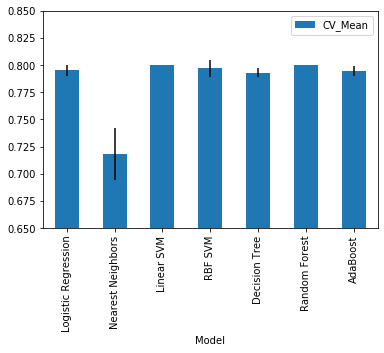

In [20]:
cv.plot(y='CV_Mean', yerr='CV_Std_Dev',kind='bar', ylim=[0.65, 0.85])

From the graph above, we can see that logistic regression, the SVM variants, and the Random Forest model all perform similarly and post good metric scores. On the other hand, our KNN classifier performed by far the worst. This can be expected seeing that we arbitrarily chose the value of `k` as 3 for that model.  

This last point brings us back full circle to the introduction where we spoke about **iteration**: having performed our initial analysis, we can now ask several further questions of our modeling problem:

 - Should we continue to investigate the performance of the KNN model under different settings of `k`? 
 - Seeing that most of the scores are very similar, should we try to use additional metrics to better differentiate model performance? Perhaps we just need to add some more of our original data?  
 - Is performance the only aspect we care about for our given task? Should we focus on other model characteristics such as execution time, or memory consumption?   
 - Are the current scores good enough? If not, should we investigate more models or instead focus on improving the current ones through techniques such as hyperparameter tuning? 
 
Obviously we can see that there are a lot of questions, and this list isn't even complete! But don't let that intimidate you; part of becoming a competent data scientist is knowing which of these questions is most pertinent for the task you are required to complete. It is something which will take practice and the application of your very capable mind!  


## Conclusion

That is a lot of classifiers! In this train we built seven different classification models and trained these on the MBTI dataset. To ensure that we got a robust measure of classifier performance, we then applied cross validation on these models. Performing this analysis allowed us to reflect on our problem at hand; generating further questions to lead us along the iterative process of improving our model-based solution.  